## Configure environment

In [1]:
%%capture
%pip install torch torchvision h5py xarray matplotlib netcdf4

In [2]:
import random
import time
import os
import datetime
import itertools
import math
import sys
from random import randint

import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torch.optim.lr_scheduler import ReduceLROnPlateau
import torch.utils.data as data
from torch.utils.data import DataLoader
import numpy as np
import h5py
import PIL.Image
from IPython.core import display as idisplay
import matplotlib.pyplot as plt
import xarray as xr

from vae import VAE, vae_loss_fn
sys.path.append('../common')
import common

In [3]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cpu


In [4]:
common.set_memory_limit_if_not_limit(1.5)

In [5]:
os.makedirs('save', exist_ok=True)

## Load data

In [6]:
cwd = os.getcwd()
pardir = os.path.dirname(os.path.dirname(cwd))
data_folder = os.path.join(pardir,'data')
data_path = os.path.join(data_folder,'video_prediction_dataset.hdf5')
mask_path = os.path.join('assets','mask_black_skygptdata.png')
model_name = 'CNNLSTM'
output_path = os.path.join(cwd,"save", f"{model_name}.torch")
with h5py.File(data_path, 'r') as fds:
    group_names = list(fds.keys())
    print(group_names)

dss = {}
for gname in group_names:
    dss[gname] = xr.open_dataset(data_path, group=gname)

['test', 'trainval']


In [7]:
print(dss['test']['images_log'])
print(dss['test']['images_log'].shape)

<xarray.DataArray 'images_log' (phony_dim_0: 4467, phony_dim_1: 16,
                                phony_dim_2: 64, phony_dim_3: 64, phony_dim_4: 3)> Size: 878MB
[878247936 values with dtype=uint8]
Dimensions without coordinates: phony_dim_0, phony_dim_1, phony_dim_2,
                                phony_dim_3, phony_dim_4
(4467, 16, 64, 64, 3)


In [8]:
mask_png = np.array(PIL.Image.open(mask_path).resize((64, 64)).getdata())
# Mask for size 64
print(mask_png.shape)
mask_to_black = (mask_png[:,3] > 127)
not_mask_to_black = (mask_png[:,3] <= 127)
print(mask_to_black.sum()) # alpha = 1 = black visible
print(not_mask_to_black.sum())
print(not_mask_to_black.sum()+mask_to_black.sum())
mask_to_black = mask_to_black.reshape((64, 64))
empty_mask = np.ones((64, 64, 3))
mask_to_black = np.where(np.expand_dims(mask_to_black, 2), empty_mask, empty_mask*0)


(4096, 4)
1674
2422
4096


In [9]:
bs = 32 # batch size
transform = transforms.Compose([
    transforms.Lambda(lambda x: np.where(mask_to_black, x*0, x)),
    transforms.ToPILImage(), # This already normalizes the image
    transforms.Resize(64),
    transforms.ToTensor(),
    #transforms.Lambda(lambda x: x.float()),
    #transforms.Normalize(mean=[0.5], std=[0.5])  # Example normalization
])
# Create Dataset and DataLoader
train_dataset = common.VideoDataset(dss['trainval']['images_log'], dss['trainval']['images_pred'], transform=transform, stack_videos=True)
train_loader = DataLoader(train_dataset, batch_size=bs, shuffle=True)

test_dataset = common.VideoDataset(dss['test']['images_log'], dss['test']['images_pred'], transform=transform)
test_loader = DataLoader(test_dataset, batch_size=bs, shuffle=False)

print(f"Number of videos: {len(train_dataset.videos)}.")
print(f"Number of video batches: {len(train_loader)}")
print(f"Size of video batches: {bs}.")

Number of videos: 53336.
Number of video batches: 1667
Size of video batches: 32.


torch.Size([31, 3, 64, 64])
Number of images per video: 31
Number of images per batch: 992


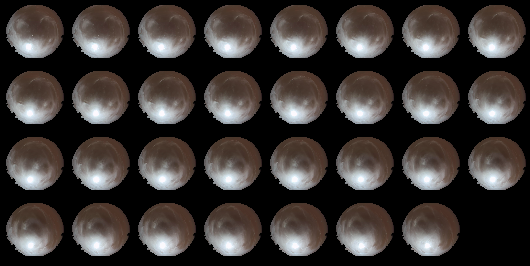

In [10]:
# Fixed input for debugging
fixed_x = next(iter(train_loader))
print(fixed_x[0].shape) # 0 because VideoDataset has batch_size videos, not images.
print(f"Number of images per video: {fixed_x[0].shape[0]}")
print(f"Number of images per batch: {fixed_x[0].shape[0]*bs}")
torchvision.utils.save_image(fixed_x[0], 'save/real_image.png')
idisplay.Image('save/real_image.png')

In [11]:
#cnn = torch.nn.Conv2d()
#rnn = torch.nn.LSTM()

In [12]:
image_channels = fixed_x[0].size(1)

In [13]:
vae = VAE(image_channels=image_channels).to(device)
if os.path.exists(output_path):
    vae.load_state_dict(torch.load(output_path, map_location='cpu'))
else:
    print('No states loaded')

No states loaded


In [14]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)
print(count_parameters(vae))

4348547


In [15]:
optimizer = torch.optim.Adam(vae.parameters(), lr=1e-3) 

In [16]:
epochs = 20

In [17]:
for epoch in range(epochs):
    vae.train()
    for idx, (videos) in enumerate(train_loader):
        images = torch.stack([img[randint(0, len(img)-1)] for img in videos])
        # Only taking the first into account, all images of videos are very similar
        #images = videos.flatten(0,1)
        recon_images, mu, logvar = vae(images)
        loss, bce, kld = vae_loss_fn(recon_images, images, mu, logvar)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if idx % 10 == 0:
            to_print = (
                f"Epoch[{epoch+1}/{epochs}] B[{idx+1}/{len(train_loader)}] Loss: {loss.data.item()/bs:.4g} "
                f"{bce.data.item()/bs:.4g} {kld.data.item()/bs:.3g}"
            )
            print(to_print)
    torch.save(vae.state_dict(), 'vae.torch')


Epoch[1/20] B[1/1667] Loss: 0.02196 0.02195 1.14e-05
Epoch[1/20] B[11/1667] Loss: 0.01982 0.01981 1.08e-05
Epoch[1/20] B[21/1667] Loss: 0.01566 0.01561 4.98e-05
Epoch[1/20] B[31/1667] Loss: 0.01345 0.01345 3.61e-06
Epoch[1/20] B[41/1667] Loss: 0.01288 0.01288 6.61e-07
Epoch[1/20] B[51/1667] Loss: 0.01268 0.01268 2.04e-07
Epoch[1/20] B[61/1667] Loss: 0.01258 0.01258 5.06e-08
Epoch[1/20] B[71/1667] Loss: 0.01257 0.01257 6.35e-08
Epoch[1/20] B[81/1667] Loss: 0.0124 0.0124 7.75e-08
Epoch[1/20] B[91/1667] Loss: 0.01245 0.01245 1.76e-07
Epoch[1/20] B[101/1667] Loss: 0.01239 0.01239 2.33e-07
Epoch[1/20] B[111/1667] Loss: 0.01244 0.01243 3.49e-07
Epoch[1/20] B[121/1667] Loss: 0.01246 0.01246 3.88e-07
Epoch[1/20] B[131/1667] Loss: 0.01242 0.01242 2.73e-07
Epoch[1/20] B[141/1667] Loss: 0.01237 0.01237 3.51e-07
Epoch[1/20] B[151/1667] Loss: 0.01236 0.01236 2.91e-07
Epoch[1/20] B[161/1667] Loss: 0.01244 0.01244 3.07e-07
Epoch[1/20] B[171/1667] Loss: 0.01246 0.01246 3.26e-07
Epoch[1/20] B[181/1667]

In [ ]:
def compare(x):
    recon_x, _, _ = vae(x)
    return torch.cat([x, recon_x])

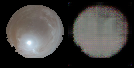

In [ ]:
vae.eval()
fixed_x = train_dataset[randint(1, 100)][0].unsqueeze(0)
compare_x = compare(fixed_x)

torchvision.utils.save_image(compare_x.data.cpu(), 'save/sample_image.png')
display(idisplay.Image('save/sample_image.png', width=700, unconfined=True))